In [39]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # ESTA LINEA SE USA
import networkx as nx
import numpy as np
import pandas as pd
import os
# import geopandas as gpd
import requests  # Para obtener los datos directamente desde la página
# import recursos as recs # estructuras de datos y funciones (los saqué para que no ocupen espacio en el notebook)
# import scipy
import seaborn as sns
import seaborn.objects as so

from io import BytesIO # Para convertir el excel
from pathlib import Path


In [40]:
from mpl_toolkits.basemap import Basemap  # Librería del mapa

# **Preparación de los datos**

## Descarga

In [41]:
# Descargo el documento
url = 'https://www.un.org/development/desa/pd/sites/www.un.org.development.desa.pd/files/undesa_pd_2024_ims_stock_by_sex_destination_and_origin.xlsx'
headers = {'User-Agent': 'Mozilla/5.0'}
respuesta = requests.get(url, headers=headers)
doc_excel = BytesIO(respuesta.content)

# Obtengo y ordeno los datos
migraciones = pd.read_excel(doc_excel, sheet_name='Table 1') # Me quedo solo con la primer plantilla
migraciones = migraciones.iloc[9:, :15].reset_index(drop=True) # Me con las filas donde están realmente los datos (ambos sexos, sin deglose)
migraciones.columns = migraciones.iloc[0].astype(str) # Asigno la primer fila como encabezado
migraciones = (
    migraciones[1:].reset_index(drop=True) # Elimino la fila y limpio los nombres de la columnas
    .rename(
        columns = {col : f'{col[:-2]}' for col in migraciones.columns if col.endswith('.0')}
    )
)

for col in migraciones.columns: # Convierto los datos de las columnas de años a enteros
    if col.isdigit():
        migraciones[col] = migraciones[col].astype('Int64').fillna(0) # Reemplazo con cero los datos faltante

columnas_de_interes = [ # Conservo los codigos de paises/regiones (para facilitar la exploración)
    'Location code of origin',
    'Region, development group, country or area of origin',
    'Location code of destination',
    'Region, development group, country or area of destination',
    '1990','1995','2000','2005','2010','2015','2020','2024',
]
migraciones = (
    migraciones[columnas_de_interes].rename(
        columns = {
            'Location code of origin': 'codigo_origen',
            'Region, development group, country or area of origin': 'origen',
            'Location code of destination': 'codigo_destino',
            'Region, development group, country or area of destination': 'destino',
        }
    )
)
migraciones.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,900,World,900,World,153916063,163176002,174566152,192788721,221020392,250042020,275284032,304021813
1,1834,Sub-Saharan Africa,900,World,14124662,15183742,14584913,16004417,18243295,22763602,27134957,30661610
2,1833,Northern Africa and Western Asia,900,World,14986109,17216219,18728264,21198002,25429492,32508087,37196853,40529326
3,1831,Central and Southern Asia,900,World,30342957,27930630,30008559,32445580,39400759,46011893,48594959,53948417
4,1832,Eastern and South-Eastern Asia,900,World,14465509,17262816,20822011,24315849,30053666,34562856,38223520,41409235


In [42]:
# ruta_datos = (Path(os.getcwd()) / 'migraciones-prueba.csv').resolve()
# migraciones = pd.read_csv(ruta_datos, delimiter=';')
# migraciones.info()

In [43]:
migraciones.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,900,World,900,World,153916063,163176002,174566152,192788721,221020392,250042020,275284032,304021813
1,1834,Sub-Saharan Africa,900,World,14124662,15183742,14584913,16004417,18243295,22763602,27134957,30661610
2,1833,Northern Africa and Western Asia,900,World,14986109,17216219,18728264,21198002,25429492,32508087,37196853,40529326
3,1831,Central and Southern Asia,900,World,30342957,27930630,30008559,32445580,39400759,46011893,48594959,53948417
4,1832,Eastern and South-Eastern Asia,900,World,14465509,17262816,20822011,24315849,30053666,34562856,38223520,41409235


In [44]:
type(migraciones["1990"][0])

numpy.int64

In [45]:
migraciones = migraciones.dropna()

# ESTO NO ES NCESARIO
# for col in migraciones.columns:
#     if col.isdigit(): # En las columnas de años...
#         migraciones[col] = migraciones[col].str.replace(' ', '', regex=False) # Elimino los espacios
#         migraciones[col] = migraciones[col].str.replace('..', '0', regex=False)  # Reemplazo los datos faltantes con 0
#         migraciones[col] = migraciones[col].astype(int)  # Convierto a enteros

# migraciones['origen'] = migraciones['origen'].str.replace('*', '', regex=False)
# migraciones['destino'] = migraciones['destino'].str.replace('*', '', regex=False)

In [46]:
migraciones.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,900,World,900,World,153916063,163176002,174566152,192788721,221020392,250042020,275284032,304021813
1,1834,Sub-Saharan Africa,900,World,14124662,15183742,14584913,16004417,18243295,22763602,27134957,30661610
2,1833,Northern Africa and Western Asia,900,World,14986109,17216219,18728264,21198002,25429492,32508087,37196853,40529326
3,1831,Central and Southern Asia,900,World,30342957,27930630,30008559,32445580,39400759,46011893,48594959,53948417
4,1832,Eastern and South-Eastern Asia,900,World,14465509,17262816,20822011,24315849,30053666,34562856,38223520,41409235


## Ideas
Estuve leyendo la documentacion y entiendo que los datos registran la cantidad de personas reconocidas por cada pais como migrantes, en un momento determinado. Limpié así nomás como para poder hacer unas pruebas. En todo caso se podría renombrar los países al español, corregir errores, etc..

En cuanto a los grafos en sí, se podría colorear los nodos por región, bloques o situación economómica o caulquier otra categoría que se incluya en el data set original (o que se nos ocurra).

Se me ocurre que podríamos armar un grafo por cada año disponible e ir analizando con relacion a algún evento importante que haya ocurrido cerca en el tiempo, que sucedió por regiones o por conjuntos de paises involucrados, etc. Por ejemplo, pensar los grafos sobre a una línea de tiempo donde los hitos sean acontecimientos mundiales importantes (crisis economicas, sanitarias, sociales, guerras, etc.) y usar algunos gráficos que muestren el detalle del antes y el después (aunque no sé si es lo que piden...). Esto podría incluso focalizarse por países si hay un evento que nos interesase profundizar. Por ejemplo el flujo migratorio de Argentina después del 2001, la crisis del 2008, pandemia, etc.



## Coordenadas de paises

In [47]:
colores = [  # Para identificar las aristas o nodos (por ahora se eligen al azar pero se podrían asignar)
    "#004d03","#5f33de","#51bf00","#a754ff","#00be3b","#ff4ef2","#85bd00","#48009e","#caad00","#3764ff",
    "#e79b00","#0129af","#f37200","#3095ff","#ff2d1d","#00a9fe","#ea0020","#00bd8d","#fb00c5","#00ae68",
    "#9d0095","#a9cd75","#ff54c7","#385d00","#7489ff","#927e00","#d190ff","#666e00","#730066","#ccc46b",
    "#001b52","#ff113f","#01b4b0","#ff5141","#01adcd","#be4300","#0059a4","#ff884a","#0182b6","#9a1400",
    "#59d4ca","#b20067","#007e54","#ff6285","#003a0b","#ff7eb2","#016f54","#ff7e79","#001804","#ff9ed6",
    "#004839","#ffa67d","#180025","#e1bc85","#59003d","#b2c8a7","#830039","#006467","#ad5a00","#016295",
    "#7c5300","#bcbcfd","#622000","#bac1d9","#330300","#e1b5d1","#3e2e00","#d3bdb9","#004052","#f4b29d",
    "#b60004","#05bc3c","#8e11a8","#cbc000","#2050da","#99ac00","#7535c1","#b6cc52","#ab6dfe","#007c1c",
    "#e24cd4","#01a85a","#da009b","#3ada9a","#aa008d","#548100","#3f7dff","#ffa825","#0045b2","#f07100",
    "#014eac","#b29000","#573395","#9fd073","#c4005a","#6dd5a2","#ff3948","#00c4dd","#d5380a","#02bafd",
    "#9e1c00","#01a5a2","#bf0036","#018d67","#ff6096","#005719","#ffa2f4","#4b5800","#b49dff","#cb7100",
    "#015998","#bb7c00","#60367d","#95d187","#782c5c","#e6bc5d","#414479","#ff9652","#01566f","#a65300",
    "#b4b8ff","#873600","#8fceb9","#8a2115","#acc9b2","#7d2f29","#dabe87","#3e4863","#ff7f74","#365027",
    "#ff8bc3","#814e00","#f3add5","#614226","#ddb7cb","#594c40","#ffa187","#5e404c","#f5b0b0","#98827d"
]

coordenadas = {
    'Burundi': (-3.3731, 29.9189),
    'Comoros': (-11.7085, 43.2547),
    'Djibouti': (11.8251, 42.5903),
    'Eritrea': (15.1794, 39.7823),
    'Ethiopia': (9.145, 40.4897),
    'Kenya': (-1.2921, 36.8219),
    'Madagascar': (-18.8792, 47.5079),
    'Malawi': (-13.2543, 34.3015),
    'Mauritius': (-20.348404, 57.552152),
    'Mayotte': (-12.8275, 45.166244),
    'Mozambique': (-25.9653, 32.5892),
    'Réunion': (-21.1151, 55.5364),
    'Rwanda': (-1.9403, 29.8739),
    'Seychelles': (-4.6796, 55.492),
    'Somalia': (2.0469, 45.3182),
    'South Sudan': (6.8769, 31.3069),
    'Uganda': (1.3733, 32.2903),
    'United Republic of Tanzania': (-6.369028, 34.888822),
    'Zambia': (-13.1339, 27.8493),
    'Zimbabwe': (-19.0158, 29.1549),
    'Angola': (-9.1895, 17.8739),
    'Cameroon': (3.848, 11.5021),
    'Central African Republic': (4.3947, 18.5582),
    'Chad': (12.1348, 15.0557),
    'Congo': (-4.4419, 15.2663),
    'Democratic Republic of the Congo': (-4.4419, 15.2663),
    'Equatorial Guinea': (1.6508, 10.2679),
    'Gabon': (-0.8037, 11.6094),
    'Sao Tome and Principe': (0.1864, 6.6131),
    'Algeria': (28.0339, 1.6596),
    'Egypt': (26.8206, 30.8025),
    'Libya': (26.3351, 17.2283),
    'Morocco': (31.7917, -7.0926),
    'Sudan': (12.8628, 30.2176),
    'Tunisia': (33.8869, 9.5375),
    'Botswana': (-22.3285, 24.6849),
    'Eswatini': (-26.5225, 31.4659),
    'Lesotho': (-29.6091, 28.2336),
    'Namibia': (-22.9576, 18.4904),
    'South Africa': (-30.5595, 22.9375),
    'Benin': (9.3075, 2.3158),
    'Burkina Faso': (12.2383, -1.5616),
    'Cabo Verde': (16.002082, -24.013197),
    "Côte d'Ivoire": (7.539989, -5.547080),
    'Gambia': (13.4432, -15.3101),
    'Ghana': (7.9465, -1.0232),
    'Guinea': (9.9456, -9.6966),
    'Guinea-Bissau': (11.8037, -15.1804),
    'Liberia': (6.4281, -9.4295),
    'Mali': (17.5707, -3.9962),
    'Mauritania': (21.0079, -10.9408),
    'Niger': (17.6078, 8.0817),
    'Nigeria': (9.082, 8.6753),
    'Saint Helena': (-15.965, -5.7089),
    'Senegal': (14.6928, -17.4467),
    'Sierra Leone': (8.4606, -11.7799),
    'Togo': (8.6195, 0.8248),
    'Kazakhstan': (48.0196, 66.9237),
    'Kyrgyzstan': (41.2044, 74.7661),
    'Tajikistan': (38.8610, 71.2761),
    'Turkmenistan': (38.9697, 59.5563),
    'Uzbekistan': (41.3775, 64.5853),
    'China': (35.8617, 104.1954),
    'China, Hong Kong SAR': (22.3193, 114.1694),
    'China, Macao SAR': (22.1987, 113.5439),
    'China, Taiwan Province of China': (23.6978, 120.9605),
    "Dem. People's Republic of Korea": (40.3399, 127.5101),
    'Japan': (36.2048, 138.2529),
    'Mongolia': (46.8625, 103.8467),
    'Republic of Korea': (35.9078, 127.7669),
    'Afghanistan': (33.9391, 67.7100),
    'Bangladesh': (23.685, 90.3563),
    'Bhutan': (27.5142, 90.4336),
    'India': (20.5937, 78.9629),
    'Iran (Islamic Republic of)': (32.4279, 53.6880),
    'Maldives': (3.2028, 73.2207),
    'Nepal': (28.3949, 84.1240),
    'Pakistan': (30.3753, 69.3451),
    'Sri Lanka': (7.8731, 80.7718),
    'Brunei Darussalam': (4.5353, 114.7277),
    'Cambodia': (12.5657, 104.9910),
    'Indonesia': (-0.7893, 113.9213),
    "Lao People's Democratic Republic": (19.8563, 102.4955),
    "Malaysia": (4.2105, 101.9758),
    "Myanmar": (21.9162, 95.955974),
    "Philippines": (12.8797, 121.7740),
    "Singapore": (1.3521, 103.8198),
    "Thailand": (15.8700, 100.9925),
    "Timor-Leste": (-8.8742, 125.7275),
    "Viet Nam": (14.0583, 108.2772),
    "Armenia": (40.0691, 45.0382),
    "Azerbaijan": (40.1431, 47.5769),
    "Bahrain": (26.0667, 50.5577),
    "Cyprus": (35.1264, 33.4299),
    "Georgia": (42.3154, 43.3569),
    "Iraq": (33.2232, 43.6793),
    "Israel": (31.0461, 34.8516),
    "Jordan": (30.5852, 36.2384),
    "Kuwait": (29.3759, 47.9774),
    "Lebanon": (33.8547, 35.8623),
    "Oman": (21.5126, 55.9233),
    "Qatar": (25.3548, 51.1839),
    "Saudi Arabia": (23.8859, 45.0792),
    "State of Palestine": (31.9474, 35.2272),
    "Syrian Arab Republic": (34.8021, 38.9968),
    "Türkiye": (38.9637, 35.2433),
    "United Arab Emirates": (23.4241, 53.8478),
    "Yemen": (15.5527, 48.5164),
    "Belarus": (53.7098, 27.9534),
    "Bulgaria": (42.7339, 25.4858),
    "Czechia": (49.8175, 15.4730),
    "Hungary": (47.1625, 19.5033),
    "Poland": (51.9194, 19.1451),
    "Republic of Moldova": (47.4116, 28.3699),
    "Romania": (45.9432, 24.9668),
    "Russian Federation": (61.5240, 105.3188),
    "Slovakia": (48.6690, 19.6990),
    "Ukraine": (48.3794, 31.1656),
    "Channel Islands": (49.4657, -2.5851),
    "Denmark": (56.2639, 9.5018),
    "Estonia": (58.5953, 25.0136),
    "Faroe Islands": (61.8926, -6.9118),
    "Finland": (61.9241, 25.7482),
    "Iceland": (64.9631, -19.0208),
    "Ireland": (53.4129, -8.2439),
    "Isle of Man": (54.2361, -4.5481),
    "Latvia": (56.8796, 24.6032),
    "Lithuania": (55.1694, 23.8813),
    "Norway": (60.4720, 8.4689),
    "Sweden": (60.1282, 18.6435),
    "United Kingdom": (55.3781, -3.4360),
    "Albania": (41.1533, 20.1683),
    "Andorra": (42.5462, 1.6016),
    "Bosnia and Herzegovina": (43.9159, 17.6791),
    "Croatia": (45.1000, 15.2000),
    "Gibraltar": (36.1408, -5.3536),
    "Greece": (39.0742, 21.8243),
    "Holy See": (41.9029, 12.4534),
    "Italy": (41.8719, 12.5674),
    "Malta": (35.9375, 14.3754),
    "Montenegro": (42.7087, 19.3744),
    "North Macedonia": (41.6086, 21.7453),
    "Portugal": (39.3999, -8.2245),
    "San Marino": (43.9336, 12.4578),
    "Serbia": (44.0165, 21.0059),
    "Slovenia": (46.1512, 14.9955),
    "Spain": (40.4637, -3.7492),
    "Austria": (47.5162, 14.5501),
    "Belgium": (50.8333, 4.0),
    "France": (46.2276, 2.2137),
    "Germany": (51.1657, 10.4515),
    "Liechtenstein": (47.1660, 9.5554),
    "Luxembourg": (49.8153, 6.1296),
    "Monaco": (43.7384, 7.4246),
    "Netherlands": (52.1326, 5.2913),
    "Switzerland": (46.8182, 8.2275),
    "Anguilla": (18.2206, -63.0686),
    "Antigua and Barbuda": (17.0608, -61.7964),
    "Aruba": (12.5211, -69.9683),
    "Bahamas": (25.0343, -77.3963),
    "Barbados": (13.1939, -59.5432),
    "Bonaire": (12.1784, -68.2385),
    "Sint Eustatius and Saba": (17.4890, -62.9780),
    "British Virgin Islands": (18.4207, -64.6399),
    "Cayman Islands": (19.3133, -81.2546),
    "Cuba": (21.5218, -77.7812),
    "Curaçao": (12.1696, -68.9900),
    "Dominica": (15.4150, -61.3710),
    "Dominican Republic": (18.7357, -70.1627),
    "Grenada": (12.1165, -61.6790),
    "Guadeloupe": (16.2650, -61.5510),
    "Haiti": (18.9712, -72.2852),
    "Jamaica": (18.1096, -77.2975),
    "Martinique": (14.6415, -61.0242),
    "Montserrat": (16.7425, -62.1874),
    "Puerto Rico": (18.2208, -66.5901),
    "Saint Kitts and Nevis": (17.3578, -62.782998),
    "Saint Lucia": (13.9094, -60.9789),
    "Saint Vincent and the Grenadines": (12.9843, -61.2872),
    "Sint Maarten (Dutch part)": (18.0425, -63.0548),
    "Trinidad and Tobago": (10.6918, -61.2225),
    "Turks and Caicos Islands": (21.6940, -71.7979),
    "United States Virgin Islands": (18.3358, -64.8963),
    "Belize": (17.1899, -88.4976),
    "Costa Rica": (9.7489, -83.7534),
    "El Salvador": (13.7942, -88.8965),
    "Guatemala": (15.7835, -90.2308),
    "Honduras": (15.2000, -86.2419),
    "Mexico": (23.6345, -102.5528),
    "Nicaragua": (12.8654, -85.2072),
    "Panama": (8.5379, -80.7821),
    "Argentina": (-38.4161, -63.6167),
    "Bolivia (Plurinational State of)": (-16.2902, -63.5887),
    "Brazil": (-14.2350, -51.9253),
    "Chile": (-35.6751, -71.5430),
    "Colombia": (4.5709, -74.2973),
    "Ecuador": (-1.8312, -78.1834),
    "Falkland Islands (Malvinas)": (-51.7963, -59.5236),
    "French Guiana": (3.9339, -53.1258),
    "Guyana": (4.8604, -58.9302),
    "Paraguay": (-23.4425, -58.4438),
    "Peru": (-9.189967, -75.0152),
    "Suriname": (3.9193, -56.0278),
    "Uruguay": (-32.5228, -55.7658),
    "Venezuela (Bolivarian Republic of)": (6.4238, -66.5897),
    "Bermuda": (32.3078, -64.7505),
    "Canada": (56.1304, -106.3468),
    "Greenland": (71.7069, -42.6043),
    "Saint Pierre and Miquelon": (46.9419, -56.2711),
    "United States of America": (37.0902, -95.7129),
    "Australia": (-25.2744, 133.7751),
    "New Zealand": (-40.9006, 174.8860),
    "Melanesia": (-8.7832, 160.7000),
    "Fiji": (-17.7134, 178.0650),
    "New Caledonia": (-20.9043, 165.6180),
    "Papua New Guinea": (-6.3149, 143.9555),
    "Solomon Islands": (-9.6457, 160.1562),
    "Vanuatu": (-15.3767, 166.9592),
    "Guam": (13.4443, 144.7937),
    "Kiribati": (1.8709, -157.3630),
    "Marshall Islands": (7.1315, 171.1845),
    "Micronesia (Fed. States of)": (7.4256, 150.5508),
    "Nauru": (-0.5228, 166.9315),
    "Northern Mariana Islands": (17.3308, 145.3849),
    "Palau": (7.5149, 134.5825),
    "American Samoa": (-14.2706, -170.1322),
    "Cook Islands": (-21.2367, -159.7777),
    "French Polynesia": (-17.6797, -149.4068),
    "Niue": (-19.0544, -169.8672),
    "Samoa": (-13.7590, -172.1046),
    "Tokelau": (-9.2002, -171.8480),
    "Tonga": (-21.1789, -175.1982),
    "Tuvalu": (-7.1095, 177.6493),
    "Wallis and Futuna Islands": (-13.7688, -177.1561),
}
# Las transformo porque chatgpt me las paso al revés a como uno está acostumbrado a ubicarlos
# igualmente se podrían mejorar
for pais,coord in coordenadas.items():
    coordenadas[pais] = (coord[1], coord[0], colores[np.random.randint(139)]) # Le agregué un color a cada país

## Grafos de prueba

### Función para graficar grafos

In [48]:
def dibujar_grafo(
    G, # La instancia del grafo
    titulo:str,  # Titulo del gráfico
    medidas:tuple[int,int],  # Tamaño del gráfico
    color_fondo:str,
    pos_nodos:dict[str, tuple], # La posición de los nodos (puede generarse automaticamente con nx.spring_layout, etc.)
    tam_nodos:int,
    tam_tex_nodos:int,
    color_nodos:str,
    color_tex_nodos:str,
    color_aristas:str,
    color_tex_aristas:str,
    color_fondo_tex_aristas:str,
    tam_tex_aristas:int,
    graficar_pesos:bool,  # Indica si se dibujan o no los pesos
    aristas_con_distinto_grosor:bool, # Indica si aplica
    rango_grosor_aristas:tuple[int,int]=(1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso),
    nodos_con_distinto_color:bool=False,
    aristas_con_distinto_color:bool=False
    ):

    # Visualización del grafo
    fig = plt.figure(figsize=medidas)

    # Configuración de colores
    fig.set_facecolor(color_fondo) # Color predominante (fondo)
    ax = fig.add_subplot(1,1,1)
    ax.set_facecolor(color_fondo)  # Fondo interior donde se dibuja el grafo
    ax.axis('off') # Remueve el marco y el color blanco dentro del grafo

    # --------------------------------------------------------------------------------- Fondo de mapa (cambios en este intervalo)

    from mpl_toolkits.basemap import Basemap
    
    m = Basemap(
        projection='robin',  # proyección global tipo Robinson
        lon_0=0,             # centra el mapa en el meridiano 0
        resolution='c',
        ax=ax

    )
    
    # Dibujar el mapa de fondo
    m.drawcoastlines(color='gray')
    m.drawcountries(color='gray')
    m.fillcontinents(color='whitesmoke', lake_color='lightblue')
    m.drawmapboundary(fill_color='lightblue')

    pos_nodos = {}
    for nodo in G.nodes():
        lon, lat, _ = coordenadas[nodo]  # diccionario (lon, lat, color)
        x, y = m(lon, lat)               # convertir a coordenadas del mapa
        pos_nodos[nodo] = (x, y)

    # ----------------------------------------------------------------------------------------------------

    # Dibuja los nodos
    if nodos_con_distinto_color: # Si se elige que tengan distinto color
        color_nodos = [coordenadas[nodo][2] for nodo in G.nodes()]
    nx.draw_networkx_nodes(
        G,
        pos_nodos,
        node_size = tam_nodos,
        node_color = color_nodos,
    )

    # Dibuja las etiquetas de los nodos
    nx.draw_networkx_labels(
        G,
        pos_nodos,
        font_size = tam_tex_nodos,
        font_weight = 'bold',
        font_color = color_tex_nodos
    )

    # Si se indica, defino el grosor de las aristas en función de su peso
    if aristas_con_distinto_grosor:
        pesos = np.array([w['weight'] for _, _, w in G.edges(data=True)])  # Obtengo los pesos
        pesos_log = np.log10(pesos + 1) # Por si algún peso es 1
        grosores = ( # Normalizados al rango
            rango_grosor_aristas[0] + ((rango_grosor_aristas[1] - rango_grosor_aristas[0]) * (pesos_log - pesos_log.min())) /
            (pesos_log.max() - pesos_log.min() + 1e-9) # 1e-9 para prevenir la división por cero
        )
        # Dibujo las aristas
        for (u, v, w), grosor in zip(G.edges(data=True), grosores):
            x1, y1 = pos_nodos[u]
            x2, y2 = pos_nodos[v]
            if aristas_con_distinto_color:
                color_arista = coordenadas[u][2]
            else:
                color_arista = color_aristas
            flecha_args = dict(  # Configuración básica de cada flecha
                posA=(x1, y1),
                posB=(x2, y2),
                connectionstyle='arc3,rad=0',
                arrowstyle='-|>',
                color=color_arista,
                lw=grosor,
                mutation_scale=grosor * 7 # Hago la flecha proporcional
            )
            flecha = mpatches.FancyArrowPatch(**flecha_args)
            ax.add_patch(flecha)

    else:  # Si las aristas no tienen distinto grosor
        if aristas_con_distinto_color: # Si se elige que tengan distinto color
            color_aristas = [coordenadas[u][2] for u, v in G.edges()]
        nx.draw_networkx_edges(
            G,
            pos_nodos,
            edge_color=color_aristas,
            arrows=True,
            arrowstyle='-|>',
            arrowsize=12
        )

    # Si se indicó graficar los pesos
    if graficar_pesos:
        for u, v, w in G.edges(data=True):
            x1, y1 = pos_nodos[u]
            x2, y2 = pos_nodos[v]
            ax.text(
                (x1 + x2) / 2, # En el medio de sus aristas
                (y1 + y2) / 2,
                f"{w['weight']}",
                fontsize = tam_tex_aristas,
                color = color_tex_aristas,
                ha = 'center',
                va = 'center',
                bbox = dict(
                    facecolor=color_fondo_tex_aristas,
                    edgecolor='none'
                )
            )


    plt.title(titulo)
    plt.axis('equal')
    plt.close()
    return fig

In [49]:
migra_paises = ( # Me quedo solo con las filas de paises que estan como claves en el diccionario de coordenadas
    migraciones[ migraciones['origen'].isin(coordenadas.keys()) & migraciones['destino'].isin(coordenadas.keys())]
    .reset_index(drop=True)
)
migra_paises.head()

,codigo_origen,origen,codigo_destino,destino,1990,1995,2000,2005,2010,2015,2020,2024
0,404,Kenya,108,Burundi,186,216,202,502,847,1032,1226,1377
1,646,Rwanda,108,Burundi,221943,160197,66415,61104,54794,64363,76567,85969
2,800,Uganda,108,Burundi,1833,1546,949,805,731,891,1058,1188
3,834,United Republic of Tanzania,108,Burundi,11912,9780,5692,13732,22974,28008,33318,37409
4,180,Democratic Republic of the Congo,108,Burundi,36654,41447,37951,99099,147611,175768,199585,224091


### Primer intento *(este primer grafo tarda un ratito en generarse, pueden evitar correrlo)*

Demasiados nodos y vértices lo vuelven puro ruido.

In [50]:
# Tomo los datos globales de un año especifico y los ordeno por país de origen (alfabético) y por cantidad de migrantes (descendente)
migra_paises_1990 = (
    migra_paises[['origen', 'destino', '1990']]
    .rename(columns={'1990':'migrantes'})
    .query('migrantes != 0')
    .sort_values(by=['origen', 'migrantes'], ascending=[True, False])
)

In [51]:
# Me quedo solo con los registros que estan por arriba de la media de cada pais (para acotar un poco)
migra_mas_mediana_1990 = (
    migra_paises_1990[
        migra_paises_1990['migrantes'] >
        migra_paises_1990.groupby('origen')['migrantes'].transform('median')
    ]
    .reset_index(drop=True)
)
migra_mas_mediana_1990 = migra_mas_mediana_1990.query('origen != destino')
migra_mas_mediana_1990.head()

,origen,destino,migrantes
0,Afghanistan,Iran (Islamic Republic of),3980307
1,Afghanistan,Pakistan,3374973
2,Afghanistan,India,22737
3,Afghanistan,Russian Federation,19103
4,Afghanistan,Tajikistan,8485


#### Acá le cargo los datos a la instancia del grafo

In [52]:
# Instancia grafo
grafo_migra_1990 = nx.DiGraph()

# Agrego los vértices y aristas (cuando haya algun migrante)
for origen, destino in zip(migra_mas_mediana_1990['origen'], migra_mas_mediana_1990['destino']):
    migrantes = migra_mas_mediana_1990.loc[migra_mas_mediana_1990['destino'] == destino, 'migrantes'].sum()
    if migrantes != 0:  # Solo agrego al grafo los casos que suman
        grafo_migra_1990.add_node(f'{destino}') # Agrego el nodo
        grafo_migra_1990.add_edge( # Agrego la relación y el peso (cantidad de migrantes)
            f'{origen}',
            f'{destino}',
            weight=migrantes
        )

# Genero posiciones geográficas para los nodos
pos = {}
for nodo in grafo_migra_1990.nodes():
    x,y,_ = coordenadas[nodo]  # Me quedo solo con la latitud y longitud (descarto el color)
    pos[nodo] = (x,y)

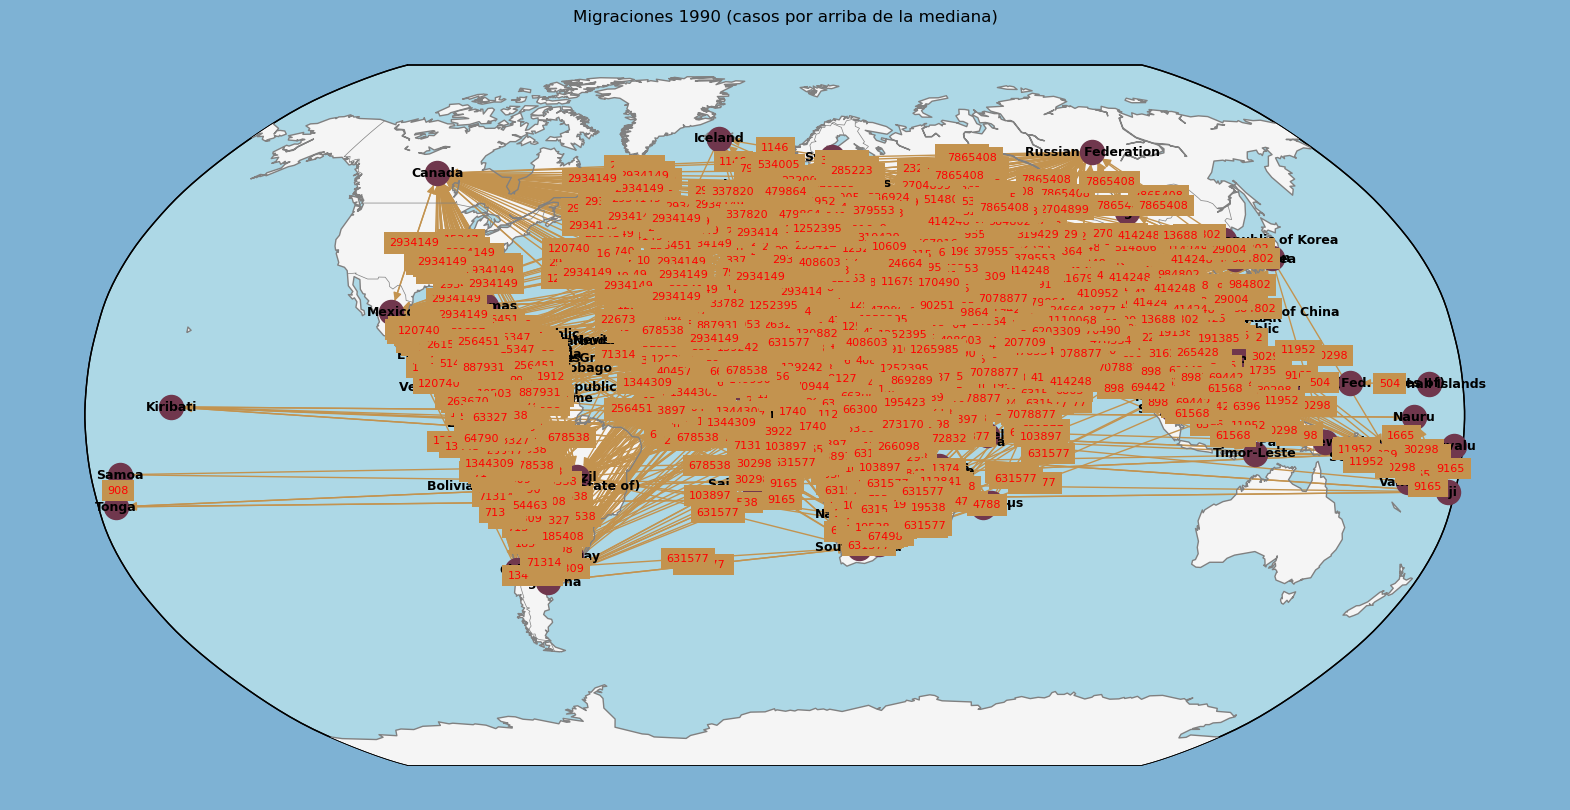

In [53]:
# Grafico
grafo = dibujar_grafo(
    grafo_migra_1990, # La instancia del grafo
    'Migraciones 1990 (casos por arriba de la mediana)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    '#70374d',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8,
    True, # Indica si se dibujan o no los pesos
    False, # Indica si las aristas tienen distinto grosor (Si False, el siguiente arg no aplica)
    # (1,7) # (1,5) por defecto: Grosor mínimo y máximo de las aristas (se calcula en función del peso)
    # False, # Nodos con distinto color
    # False, # Aristas con distinto color
)

display(grafo)

### Segundo intento: menos nodos y menos aristas

Se vuelve un poco más manejable. Por otra parte, se puede acompañar el analisis con otros graficos para hacer todo mas interpretable.

In [54]:
# Me voy a quedar solo con los datos del 95 que tienen como origen a los paises del conjunto
sur = {
    "Nicaragua",
    "Panama",
    "Argentina",
    "Bolivia (Plurinational State of)",
    "Brazil",
    "Chile",
    "Colombia",
    "Ecuador",
    "Falkland Islands (Malvinas)",
    "French Guiana",
    "Guyana",
    "Paraguay",
    "Peru",
    "Suriname",
    "Uruguay",
    "Venezuela (Bolivarian Republic of)"
}

# Tomo los datos globales de un año especifico y los ordeno por país de origen (alfabético) y por cantidad de migrantes (descendente)
migra_sur_95 = (
    migra_paises[['origen', 'destino', '1995']]
    .rename(columns={'1995':'migrantes'})
    .query('migrantes != 0 & origen in @sur & origen != destino')  # @ para referenciar a variable externa al df
    .sort_values(by=['origen', 'migrantes'], ascending=[True, False])
    .reset_index(drop=True)
)

# Me quedo solo con los primeros 5 destinos de cada pais (para acotar un poco)
migra_sur_95_ppales = (
    migra_sur_95.sort_values(['origen', 'migrantes'], ascending=[True, False])
    .groupby('origen', group_keys=False)
    .head(5)
    .reset_index(drop=True)
)
migra_sur_95_ppales

,origen,destino,migrantes
0,Argentina,Paraguay,57525
1,Argentina,Italy,43178
2,Argentina,Chile,36352
3,Argentina,Israel,27834
4,Argentina,Brazil,25706
...,...,...,...
65,Venezuela (Bolivarian Republic of),Colombia,42734
66,Venezuela (Bolivarian Republic of),Italy,30614
67,Venezuela (Bolivarian Republic of),Portugal,18220
68,Venezuela (Bolivarian Republic of),Dominican Republic,15811


In [55]:
# Cargo los datos al  grafo
grafo_migra_sur_95_ppales = nx.DiGraph()

# Agrego los vértices y aristas (cuando haya algun migrante)
for origen, destino in zip(migra_sur_95_ppales['origen'], migra_sur_95_ppales['destino']):
    migrantes = migra_sur_95_ppales.loc[migra_sur_95_ppales['destino'] == destino, 'migrantes'].sum()
    if migrantes != 0:  # Solo agrego al grafo los casos que suman
        grafo_migra_sur_95_ppales.add_node(f'{destino}') # Agrego el nodo
        grafo_migra_sur_95_ppales.add_edge( # Agrego la relación y el peso (cantidad de migrantes)
            f'{origen}',
            f'{destino}',
            weight=migrantes
        )


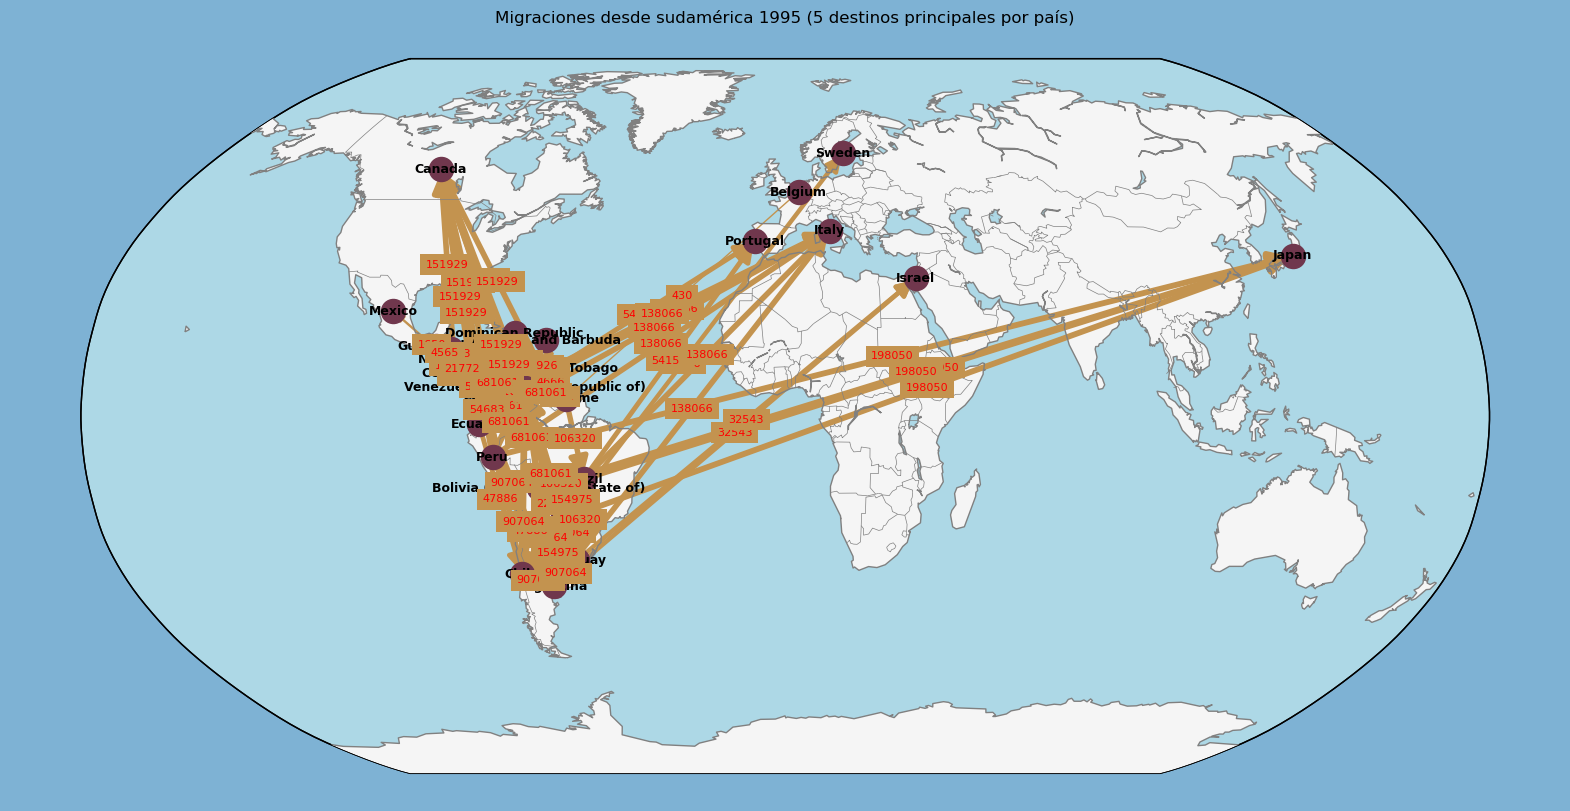

In [56]:
# Grafico

grafo1 = dibujar_grafo(
    grafo_migra_sur_95_ppales, # La instancia del grafo
    'Migraciones desde sudamérica 1995 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    '#70374d',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    True, # Indica si se dibujan o no los pesos
    True, # Indica si las aristas tienen distinto grosor
    (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso)
    # False, # Nodos con distinto color
    # False, # Aristas con distinto color
)
display(grafo1)


In [57]:
""" # Este gráfico tira error
# Grafico
grafo2 = dibujar_grafo(
    grafo_migra_sur_95_ppales, # La instancia del grafo
    'Migraciones desde sudamérica 1995 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    '#70374d',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    False, # Indica si se dibujan o no los pesos
    True, # Indica si las aristas tienen distinto grosor
    (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso)
    # False, # Nodos con distinto color
    # False, # Aristas con distinto color
)
display(grafo2)
"""

" # Este gráfico tira error\n# Grafico\ngrafo2 = dibujar_grafo(\n    grafo_migra_sur_95_ppales, # La instancia del grafo\n    'Migraciones desde sudamérica 1995 (5 destinos principales por país)', # titulo\n    (20,10), # tamaño de figura\n    '#7eb2d4', # color de fondo\n    pos, # posiciones de los nodos\n    300,  # tamaño nodos\n    9,  # tamaño texto nodos\n    '#70374d',  # color nodos\n    'black', # color de texto nodos\n    '#c3934f',  # color de aristas\n    '#c3934f', # color de fondo de caja de texto aristas\n    8, #  tamaño de texto aristas\n    False, # Indica si se dibujan o no los pesos\n    True, # Indica si las aristas tienen distinto grosor\n    (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso)\n    # False, # Nodos con distinto color\n    # False, # Aristas con distinto color\n)\ndisplay(grafo2)\n"

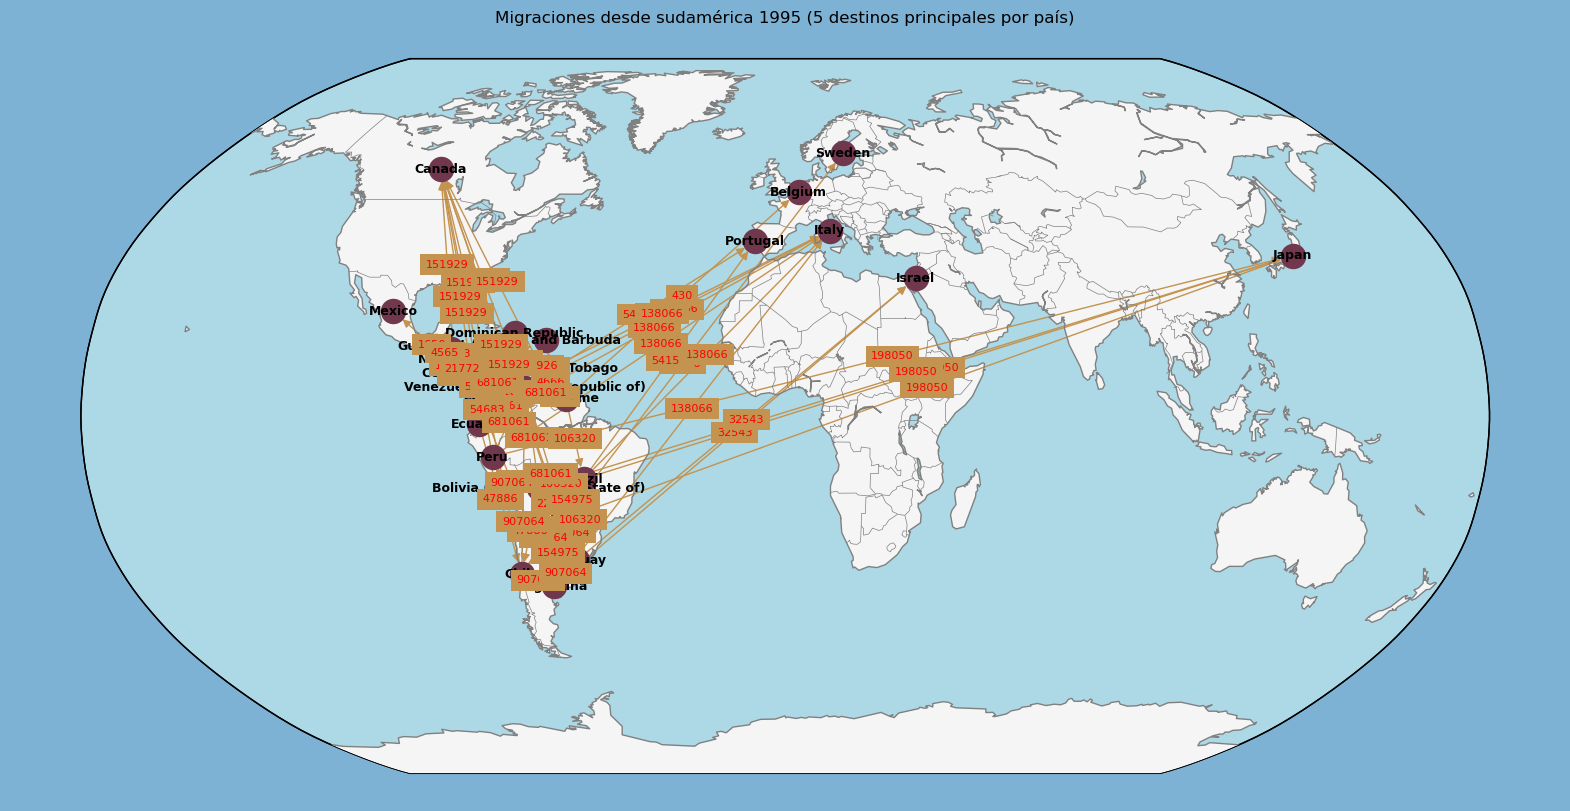

In [58]:
# Grafico
grafo3 = dibujar_grafo(
    grafo_migra_sur_95_ppales, # La instancia del grafo
    'Migraciones desde sudamérica 1995 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    '#70374d',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    True, # Indica si se dibujan o no los pesos
    False, # Indica si las aristas tienen distinto grosor
    # (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso)
    # False, # Nodos con distinto color
    # False, # Aristas con distinto color
)
display(grafo3)

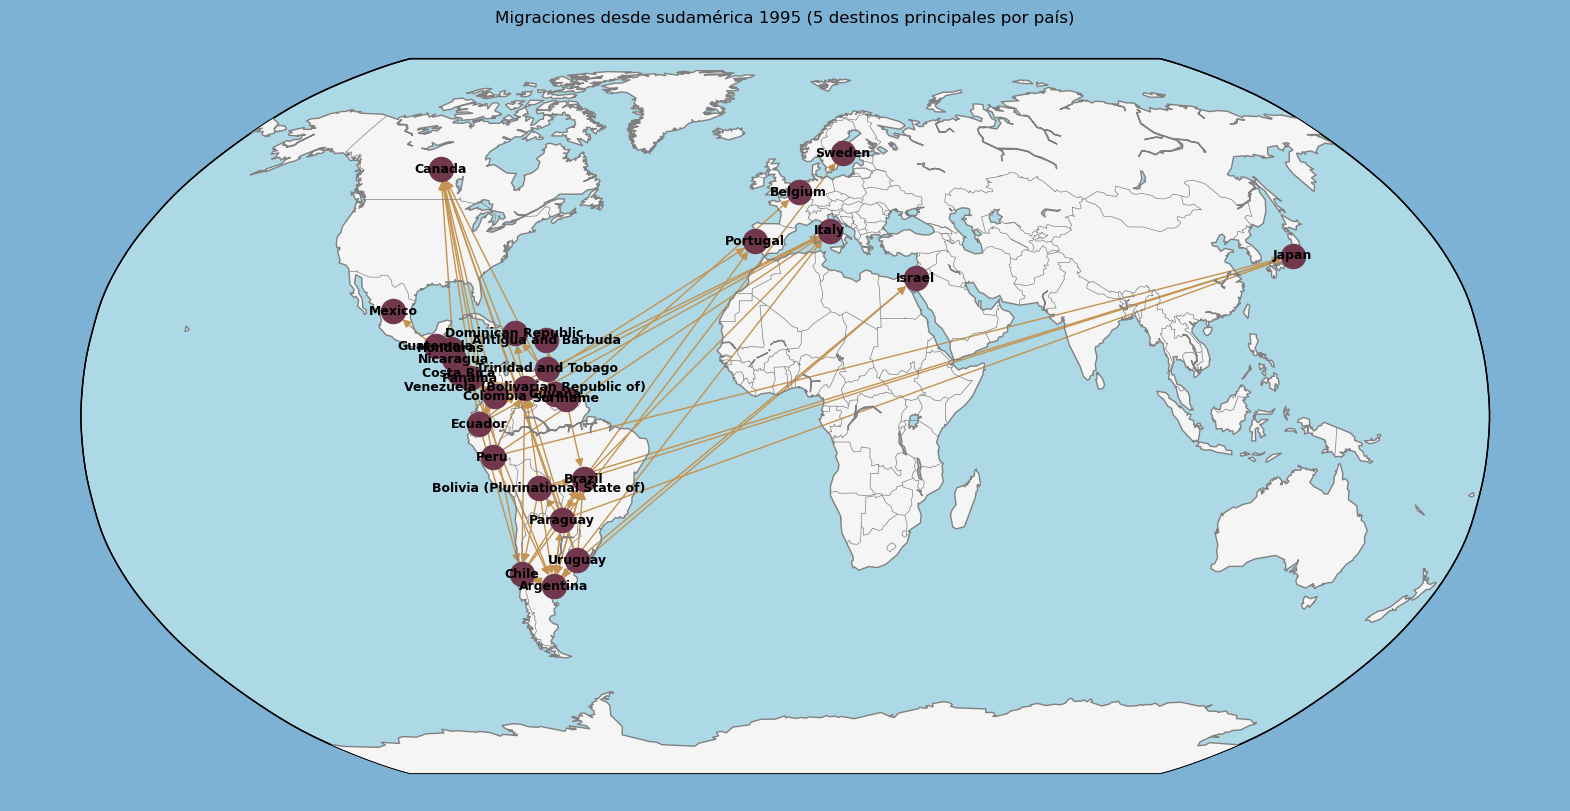

In [59]:
# Grafico
grafo4 = dibujar_grafo(
    grafo_migra_sur_95_ppales, # La instancia del grafo
    'Migraciones desde sudamérica 1995 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    '#70374d',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    False, # Indica si se dibujan o no los pesos
    False, # Indica si las aristas tienen distinto grosor
    # (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso)
    # False, # Nodos con distinto color
    # False, # Aristas con distinto color
)
display(grafo4)

## Tercer intento

In [60]:
# Me voy a quedar solo con los datos del 2024
mercosur = {  # Miembros y asociados
    "Panama",
    "Argentina",
    "Brazil",
    "Chile",
    "Colombia",
    "Ecuador",
    "Guyana",
    "Paraguay",
    "Peru",
    "Suriname",
    "Uruguay",
}

# Tomo los datos globales de un año especifico y los ordeno por país de origen (alfabético) y por cantidad de migrantes (descendente)
migra_mercosur_24 = (
    migra_paises[['origen', 'destino', '2024']]
    .rename(columns={'2024':'migrantes'})
    .query('migrantes != 0 & origen in @mercosur & origen != destino')
    .sort_values(by=['origen', 'migrantes'], ascending=[True, False])
    .reset_index(drop=True)
)

# Me quedo solo con los primeros 5 destinos de cada pais (para acotar un poco)
migra_mercosur_24_ppales = (
    migra_mercosur_24.sort_values(['origen', 'migrantes'], ascending=[True, False])
    .groupby('origen', group_keys=False)
    .head(5)
    .reset_index(drop=True)
)

In [61]:
# Cargo los datos al  grafo
grafo_migra_mercosur_24_ppales = nx.DiGraph()

# Agrego los vértices y aristas (cuando haya algun migrante)
for origen, destino in zip(migra_mercosur_24_ppales['origen'], migra_mercosur_24_ppales['destino']):
    migrantes = migra_mercosur_24_ppales.loc[migra_mercosur_24_ppales['destino'] == destino, 'migrantes'].sum()
    grafo_migra_mercosur_24_ppales.add_node(f'{destino}') # Agrego el nodo
    grafo_migra_mercosur_24_ppales.add_edge( # Agrego la relación y el peso (cantidad de migrantes)
        f'{origen}',
        f'{destino}',
        weight=migrantes
    )


# Genero posiciones geográficas para los nodos
pos = {}
for nodo in grafo_migra_mercosur_24_ppales.nodes():
    x,y,_ = coordenadas[nodo]  # Me quedo solo con la latitud y longitud (descarto el color)
    pos[nodo] = (x,y)

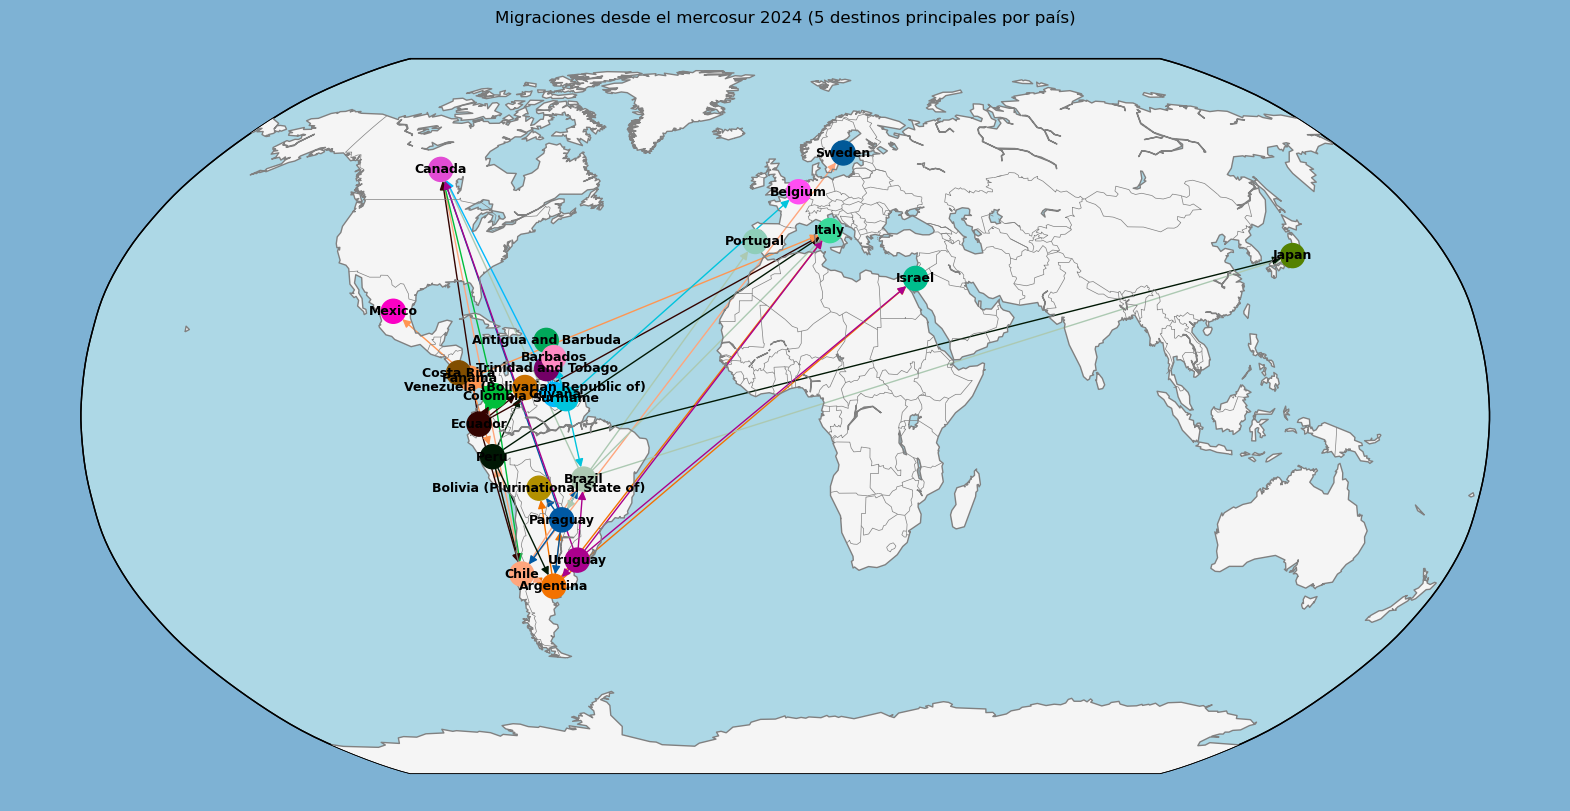

In [62]:
# Grafico
grafo5 = dibujar_grafo(
    grafo_migra_mercosur_24_ppales, # La instancia del grafo
    'Migraciones desde el mercosur 2024 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    300,  # tamaño nodos
    9,  # tamaño texto nodos
    'gray',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    False, # Indica si se dibujan o no los pesos
    False, # Indica si las aristas tienen distinto grosor
    (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso),
    True, # Nodos con distinto color
    True, # Aristas con distinto color
)
display(grafo5)

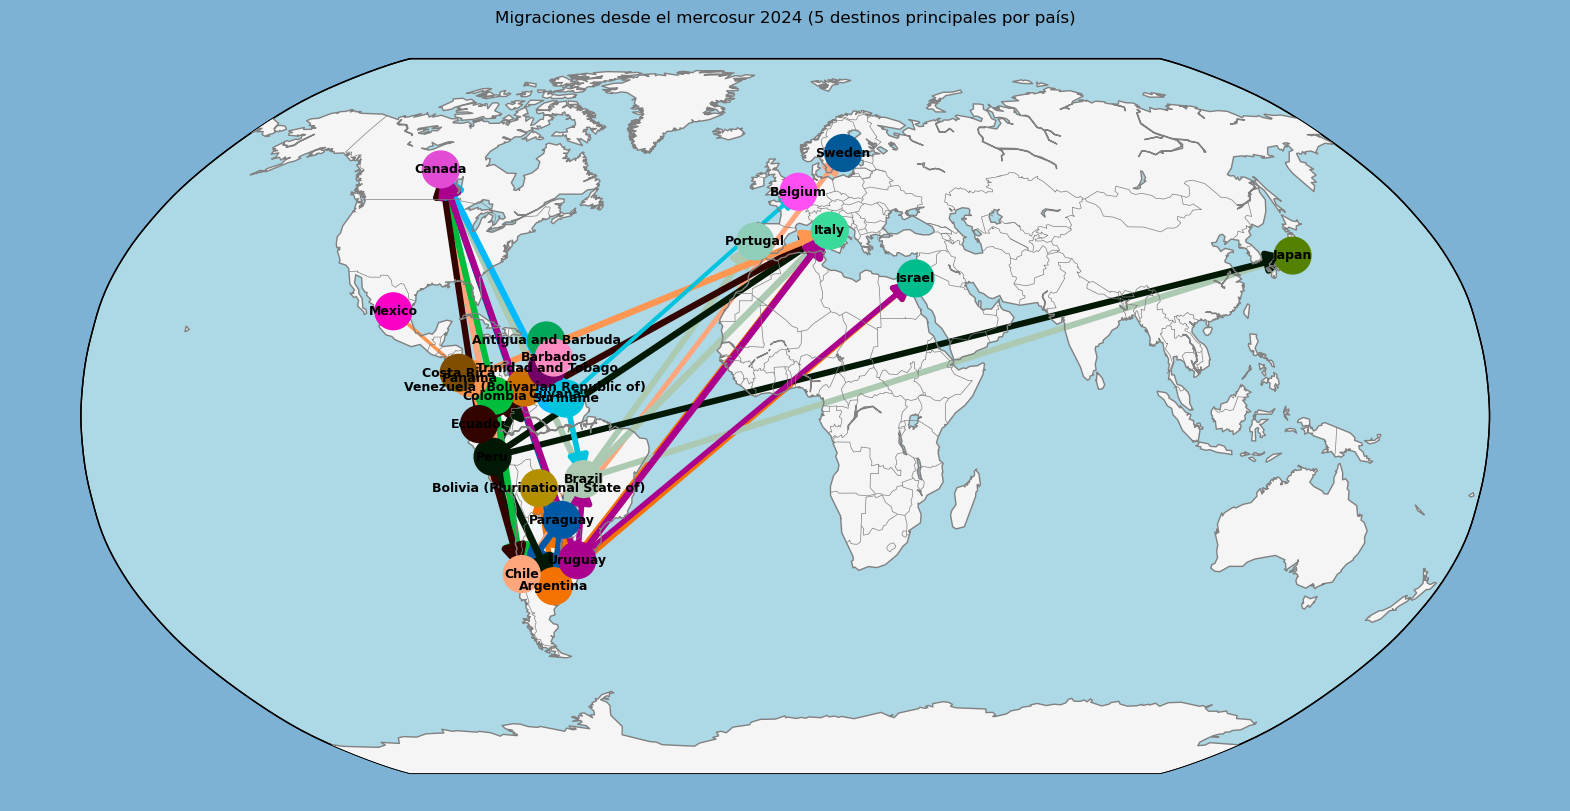

In [63]:
# Grafico
grafo6 = dibujar_grafo(
    grafo_migra_mercosur_24_ppales, # La instancia del grafo
    'Migraciones desde el mercosur 2024 (5 destinos principales por país)', # titulo
    (20,10), # tamaño de figura
    '#7eb2d4', # color de fondo
    pos, # posiciones de los nodos
    700,  # tamaño nodos
    9,  # tamaño texto nodos
    'gray',  # color nodos
    'black', # color de texto nodos
    '#c3934f',  # color de aristas
    'red', # color de texto aristas
    '#c3934f', # color de fondo de caja de texto aristas
    8, #  tamaño de texto aristas
    False, # Indica si se dibujan o no los pesos
    True, # Indica si las aristas tienen distinto grosor
    (1,5), # Grosor mínimo y máximo de las aristas (se calcula en función del peso),
    True, # Nodos con distinto color
    True, # Aristas con distinto color
)
display(grafo6)